# Assignment 7

CS4172 Machine Learning Lab

Name: Indranil Bain

Enrolment Number: 2020CSB039

## Task 1

Download and preprocess the sentiment analysis dataset from https://www.kaggle.com/snap/amazon-fine-food-reviews. Download the Glove word vectors from http://nlp.stanford.edu/data/glove.6B.zip and extract the 100-dimensional file (glove.6B.100d.txt) from the zipped folder.

## Task 2

Preprocess the review dataset by considering the column “review score” >3 as positive reviews and others as negative reviews. For training on local machine considers 5000 positive and negative reviews each for the training dataset.

Consider 2000 reviews for the test dataset and validation dataset each. Strip the length of each review sentence (number of words) according to your computation availability.

In [2]:
import tensorflow as tf
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # ignore CUDA messages

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
AMAZON_REVIEW_PATH = "./../ML_DRIVE/Assign_7/Amazon Review/Reviews.csv"
GLOVE_FILE_PATH = "./../ML_DRIVE/Assign_7/glove.6B/glove.6B.100d.txt"

# https://keras.io/examples/nlp/pretrained_word_embeddings/


In [ ]:
import pandas as pd

review_df = pd.read_csv(AMAZON_REVIEW_PATH)
review_df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
review_df.columns


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [ ]:
columns_to_keep = ['Score', 'Summary', 'Text']

review_df = review_df[columns_to_keep]

review_df.iloc[0:1]


,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...


In [ ]:
# merge summary and text (summary in front)

review_df['full_review'] = review_df['Summary'] + ' ' + review_df['Text']
review_df = review_df.drop(['Summary', 'Text'], axis=1)

review_df.iloc[0:1]


,Score,full_review
0,5,Good Quality Dog Food I have bought several of...


In [ ]:
# 1 is true, 0 is false
import numpy as np
review_df['review score'] = np.where(review_df.Score > 3, 1, 0)
review_df = review_df.drop(['Score'], axis=1)
review_df


,full_review,review score
0,Good Quality Dog Food I have bought several of...,1
1,Not as Advertised Product arrived labeled as J...,0
2,"""Delight"" says it all This is a confection tha...",1
3,Cough Medicine If you are looking for the secr...,0
4,Great taffy Great taffy at a great price. The...,1
...,...,...
568449,Will not do without Great for sesame chicken.....,1
568450,disappointed I'm disappointed with the flavor....,0
568451,Perfect for our maltipoo These stars are small...,1
568452,Favorite Training and reward treat These are t...,1


In [ ]:
# taking 2000 samples for test and validation dataset

test_df = review_df.sample(2000, random_state=100)
val_df = review_df.sample(2000, random_state=100)
review_df = review_df.drop(test_df.index.tolist() + val_df.index.tolist())


In [ ]:
# review df does not contain the rows in test_df and val_df
review_df


,full_review,review score
0,Good Quality Dog Food I have bought several of...,1
1,Not as Advertised Product arrived labeled as J...,0
2,"""Delight"" says it all This is a confection tha...",1
3,Cough Medicine If you are looking for the secr...,0
4,Great taffy Great taffy at a great price. The...,1
...,...,...
568449,Will not do without Great for sesame chicken.....,1
568450,disappointed I'm disappointed with the flavor....,0
568451,Perfect for our maltipoo These stars are small...,1
568452,Favorite Training and reward treat These are t...,1


In [ ]:
true_df = review_df[review_df['review score'] == 1]
false_df = review_df[review_df['review score'] == 0]

true_df = true_df.sample(5000, random_state=100)
false_df = false_df.sample(5000, random_state=100)

train_df = pd.concat([true_df, false_df]).sort_index()

train_df


,full_review,review score
29,The Best Hot Sauce in the World I don't know i...,1
76,Good These looked like a perfect snack to thro...,1
112,My every day green tea I have been drinking Ro...,1
131,"Not for me I must be a bit of a wuss, because ...",0
174,Great but not as good as it was back in the da...,1
...,...,...
568124,"The Perfect K-cup, 40 Years in the Making Firs...",1
568128,"Good, but not Great I live near Seattle and ha...",0
568206,Little peppers - BIG TASTE! 3/23/11 South New...,1
568413,premium edge cat food My cats don't like it. w...,0


In [ ]:
# using TextVectorization to index the vocabulary
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(output_sequence_length=100)
vectorizer.adapt(train_df['full_review'].to_list())


In [ ]:
# Note the first two are default
# "empty" and "unknown" vocabulary word
vectorizer.get_vocabulary()[:5]


['', '[UNK]', 'the', 'i', 'and']

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

# Now we have the vocabulary encoding of all the words
# in the training dataset in the vectorizer


In [ ]:
# converting the glove file,
# where every line is "word coefs" into a dict

import numpy as np

embedding_index = {}

with open(GLOVE_FILE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, dtype=float, sep=" ")
        embedding_index[word] = coefs

print(f"Found {len(embedding_index)} word vectors.")


Found 400000 word vectors.


In [ ]:
# now converting it into an embedding layer for using it directly on model
# for more info about embedding layer: https://medium.com/analytics-vidhya/understanding-embedding-layer-in-keras-bbe3ff1327ce#:~:text=Embedding%20layer%20enables%20us%20to,way%20along%20with%20reduced%20dimensions.

num_tokens = len(voc) + 2  # +2 for "empty" and "unknown"
embedding_dim = 100  # cause using glove 100 model
hits = 0  # number of words in vocabulary that are also in the glove map
misses = 0  # number of words in vocabulary that are not in the glove map

# Prepare embedding matrix
# embedding_matrix[i] will be the 100 dimension list
# i is the index made using vocabulary using the vectorizer
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)

    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print(f"Converted {hits} word, {misses} misses")


Converted 18119 word, 10389 misses


In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Embedding

glove_embedding = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


In [ ]:
# Now the basic idea
# word -> encoded number using vectorizer ->
# convert to 100d vector using embedding layer -> neural network


In [ ]:
x_train = vectorizer(
    np.array(
        [[s] for s in train_df['full_review'].tolist()]
    )
).numpy()

x_val = vectorizer(
    np.array(
        [[s] for s in val_df['full_review'].tolist()]
    )
).numpy()

x_test = vectorizer(
    np.array(
        [[s] for s in test_df['full_review'].tolist()]
    )
).numpy()


In [ ]:
from tensorflow.keras.utils import to_categorical


y_train = to_categorical(train_df['review score'].tolist())
y_val = to_categorical(val_df['review score'].tolist())
y_test = to_categorical(test_df['review score'].tolist())


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import \
    Dense, Input, LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import time
from keras.utils.layer_utils import count_params

# set figure size
plt.rcParams['figure.figsize'] = [12, 5]


def train_model(
    x_train,
    y_train,
    x_val,
    y_val,
    rnn_type: str,
    num_rnn_layers: int,
    rnn_layer_unit: int,
    embedding_layer_type: str,
    bidirectional: bool,
    rnn_drop_rate: float,
    drop_rate: float,
    num_epochs: int = 30,
    give_model=False
):
    model = Sequential()
    model.add(Input(shape=(None, ), dtype="int64"))

    if embedding_layer_type == 'glove':
        model.add(glove_embedding)
    elif embedding_layer_type == 'trainable_embedding':
        model.add(Embedding(num_tokens, embedding_dim))
    elif embedding_layer_type == 'one_hot':
        model.add(
            Embedding(np.ones((num_tokens, num_tokens)), trainable=False)
        )

    else:
        raise Exception('Error: undefined embedding_layer_type')

    # return_sequences=True does not reduce the Dimension Count of Output
    for _ in range(0, num_rnn_layers-1):
        if rnn_drop_rate != 0:
            model.add(Dropout(rnn_drop_rate))

        if bidirectional:
            if rnn_type == 'lstm':
                model.add(Bidirectional(
                    LSTM(rnn_layer_unit, activation='relu',
                         return_sequences=True)
                ))
            elif rnn_type == 'gru':
                model.add(Bidirectional(
                    GRU(rnn_layer_unit, activation='relu',
                        return_sequences=True)
                ))
            else:
                raise Exception('Error: undefined rnn_type')
        else:
            if rnn_type == 'lstm':
                model.add(
                    LSTM(rnn_layer_unit, activation='relu',
                         return_sequences=True)
                )
            elif rnn_type == 'gru':
                model.add(
                    GRU(rnn_layer_unit, activation='relu',
                        return_sequences=True)
                )
            else:
                raise Exception('Error: undefined rnn_type')

    if rnn_drop_rate != 0:
        model.add(Dropout(rnn_drop_rate))

    if bidirectional:
        if rnn_type == 'lstm':
            model.add(Bidirectional(
                LSTM(rnn_layer_unit, activation='relu')
            ))
        elif rnn_type == 'gru':
            model.add(Bidirectional(
                GRU(rnn_layer_unit, activation='relu')
            ))
        else:
            raise Exception('Error: undefined rnn_type')
    else:
        if rnn_type == 'lstm':
            model.add(LSTM(rnn_layer_unit, activation='relu'))
        elif rnn_type == 'gru':
            model.add(GRU(rnn_layer_unit, activation='relu'))
        else:
            raise Exception('Error: undefined rnn_type')

    if drop_rate != 0:
        model.add(Dropout(drop_rate))

    model.add(Dense(100, activation='relu'))
    model.add(Dense(2, activation="softmax"))
    model.summary()
    model.compile(
        loss="categorical_crossentropy", metrics=["accuracy"]
    )

    callback = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        )
    ]

    start_time = time.time()
    history = model.fit(
        x_train,
        y_train,
        epochs=num_epochs,
        validation_data=(x_val, y_val),
        callbacks=callback,
        verbose=0
    )

    if give_model:
        return model
        
    train_time = time.time() - start_time

    start_time = time.time()
    val_loss, val_acc = model.evaluate(x_val, y_val, verbose=0)
    infer_time = time.time() - start_time

    num_param = count_params(model.trainable_weights)

    plt.plot(
        history.history['loss'],
        label=f"{num_rnn_layers} layers;{rnn_type};{rnn_layer_unit} units;{embedding_layer_type} embed;bidirec {bidirectional};drop {drop_rate};rnn_drop {rnn_drop_rate}"
    )

    return num_param, val_loss, val_acc, train_time, infer_time


In [ ]:
result_df = pd.DataFrame(columns=[
    'RNN Type',
    'RNN Layer',
    'RNN Size',
    'Embedding Layer',
    'Bidirectional',
    'RNN Dropout Rate',
    'Dropout Rate',
    'Num Params',
    'Val Loss',
    'Val Accuracy',
    'Train Time (s)',
    'Infer Time (s)'
])


## Task 3

Train RNN model with the FC layer applied in the final hidden layer output using the following parameter

| Sr. No: | RNN  | RNN Layer | RNN Size | Activation | FC Layer | Embedding Layer |
|---------|------|-----------|----------|------------|----------|-----------------|
| 1       | LSTM | 1         | 64       | Relu       | 1        | Glove           |
| 2       | GRU  | 1         | 64       | Relu       | 1        | Glove           |


1 layers;lstm;64 units;glove embed;bidirec False;drop 0;rnn_drop 0 => 48942 Params;val_loss=0.5695447325706482;val_acc=0.73;train_time=240.92s;infer_time=0.47s
1 layers;gru;64 units;glove embed;bidirec False;drop 0;rnn_drop 0 => 38574 Params;val_loss=0.28342491388320923;val_acc=0.88;train_time=185.9s;infer_time=0.51s


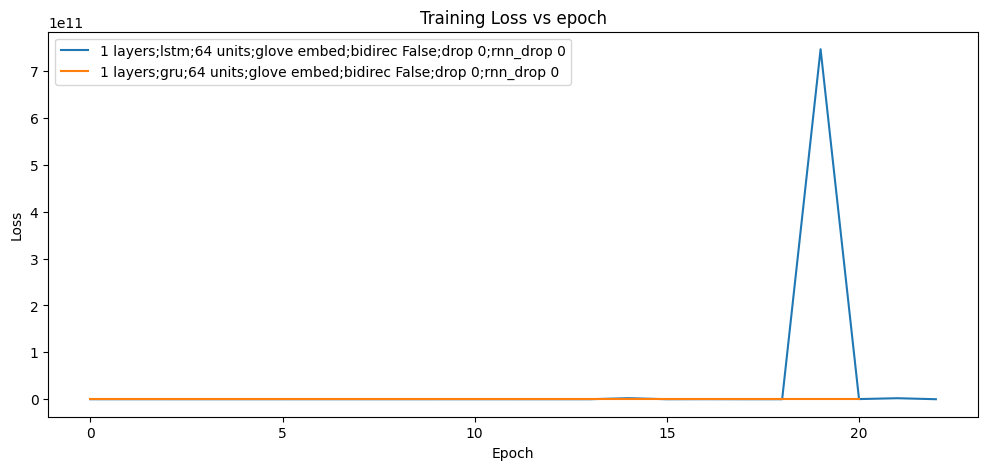

In [ ]:
rnn_types = ['lstm', 'gru']
num_rnn_layers = 1
rnn_layer_unit = 64
embedding_layer_type = 'glove'
bidirectional = False
rnn_drop_rate = 0
drop_rate = 0


for rnn_type in rnn_types:
    num_param, val_loss, val_acc, train_time, infer_time = train_model(
        x_train,
        y_train,
        x_val,
        y_val,
        rnn_type=rnn_type,
        num_rnn_layers=num_rnn_layers,
        rnn_layer_unit=rnn_layer_unit,
        embedding_layer_type=embedding_layer_type,
        bidirectional=bidirectional,
        rnn_drop_rate=rnn_drop_rate,
        drop_rate=drop_rate
    )

    print(f"{num_rnn_layers} layers;{rnn_type};{rnn_layer_unit} units;{embedding_layer_type} embed;bidirec {bidirectional};drop {drop_rate};rnn_drop {rnn_drop_rate} => {num_param} Params;val_loss={val_loss};val_acc={round(val_acc,2)};train_time={round(train_time,2)}s;infer_time={round(infer_time,2)}s")

    result_df.loc[len(result_df.index)] = [
        rnn_type,
        num_rnn_layers,
        rnn_layer_unit,
        embedding_layer_type,
        bidirectional,
        rnn_drop_rate,
        drop_rate,
        num_param,
        val_loss,
        val_acc,
        train_time,
        infer_time
    ]

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title(f'Training Loss vs epoch')
plt.show()


In [ ]:
result_df


,RNN Type,RNN Layer,RNN Size,Embedding Layer,Bidirectional,RNN Dropout Rate,Dropout Rate,Num Params,Val Loss,Val Accuracy,Train Time (s),Infer Time (s)
0,lstm,1,64,glove,False,0,0,48942,0.569545,0.7310,240.921910,0.466113
1,gru,1,64,glove,False,0,0,38574,0.283425,0.8775,185.895412,0.512385


In [ ]:
best_rnn_type = result_df.sort_values(
    by=['Val Accuracy', 'Val Loss'],
    ascending=[False, True]
)['RNN Type'].iloc[0]

best_rnn_type


'gru'

## Task 4

For the best model above vary the size of RNN : \[32,128\]

1 layers;gru;32 units;glove embed;bidirec False;drop 0;rnn_drop 0 => 16366 Params;val_loss=0.3148992359638214;val_acc=0.86;train_time=189.24s;infer_time=0.37s
1 layers;gru;128 units;glove embed;bidirec False;drop 0;rnn_drop 0 => 101422 Params;val_loss=0.29255348443984985;val_acc=0.88;train_time=225.28s;infer_time=0.61s


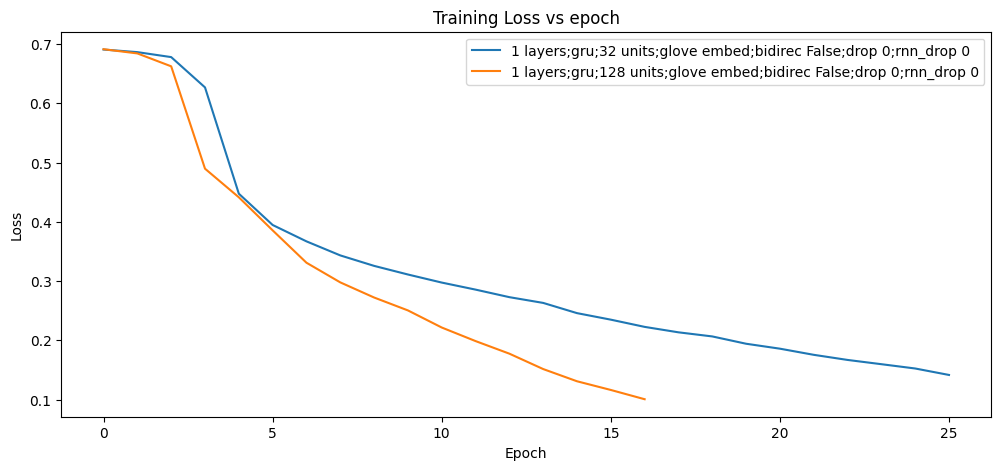

In [ ]:
num_rnn_layers = 1
rnn_layer_units = [32, 128]
embedding_layer_type = 'glove'
bidirectional = False
rnn_drop_rate = 0
drop_rate = 0


for rnn_layer_unit in rnn_layer_units:
    num_param, val_loss, val_acc, train_time, infer_time = train_model(
        x_train,
        y_train,
        x_val,
        y_val,
        rnn_type=best_rnn_type,
        num_rnn_layers=num_rnn_layers,
        rnn_layer_unit=rnn_layer_unit,
        embedding_layer_type=embedding_layer_type,
        bidirectional=bidirectional,
        rnn_drop_rate=rnn_drop_rate,
        drop_rate=drop_rate
    )

    print(f"{num_rnn_layers} layers;{best_rnn_type};{rnn_layer_unit} units;{embedding_layer_type} embed;bidirec {bidirectional};drop {drop_rate};rnn_drop {rnn_drop_rate} => {num_param} Params;val_loss={val_loss};val_acc={round(val_acc,2)};train_time={round(train_time,2)}s;infer_time={round(infer_time,2)}s")

    result_df.loc[len(result_df.index)] = [
        best_rnn_type,
        num_rnn_layers,
        rnn_layer_unit,
        embedding_layer_type,
        bidirectional,
        rnn_drop_rate,
        drop_rate,
        num_param,
        val_loss,
        val_acc,
        train_time,
        infer_time
    ]

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title(f'Training Loss vs epoch')
plt.show()


In [ ]:
result_df


,RNN Type,RNN Layer,RNN Size,Embedding Layer,Bidirectional,RNN Dropout Rate,Dropout Rate,Num Params,Val Loss,Val Accuracy,Train Time (s),Infer Time (s)
0,lstm,1,64,glove,False,0,0,48942,0.569545,0.7310,240.921910,0.466113
1,gru,1,64,glove,False,0,0,38574,0.283425,0.8775,185.895412,0.512385
2,gru,1,32,glove,False,0,0,16366,0.314899,0.8640,189.243573,0.374345
3,gru,1,128,glove,False,0,0,101422,0.292553,0.8850,225.282186,0.609460


In [ ]:
best_rnn_layer_unit = result_df.sort_values(
    by=['Val Accuracy', 'Val Loss'],
    ascending=[False, True]
)['RNN Size'].iloc[0]

best_rnn_layer_unit


128

## Task 5

For the best model above vary the number of stack layers of RNN : [2, 3, 4]. One is done previously

2 layers;gru;128 units;glove embed;bidirec False;drop 0;rnn_drop 0 => 200494 Params;val_loss=0.3106384575366974;val_acc=0.86;train_time=472.7s;infer_time=1.34s
3 layers;gru;128 units;glove embed;bidirec False;drop 0;rnn_drop 0 => 299566 Params;val_loss=0.2740836441516876;val_acc=0.89;train_time=740.85s;infer_time=1.57s
4 layers;gru;128 units;glove embed;bidirec False;drop 0;rnn_drop 0 => 398638 Params;val_loss=0.2967704236507416;val_acc=0.88;train_time=777.69s;infer_time=1.98s


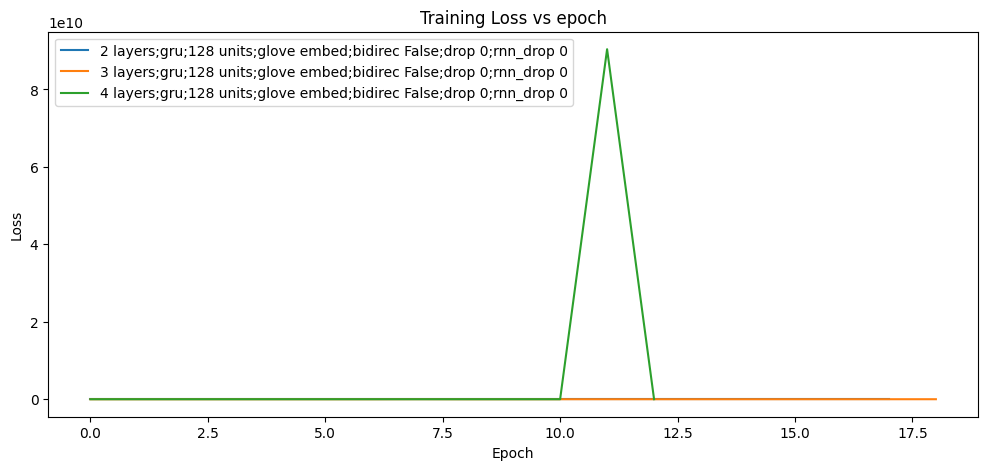

In [ ]:
num_rnn_layers = [2, 3, 4]
embedding_layer_type = 'glove'
bidirectional = False
rnn_drop_rate = 0
drop_rate = 0

for num_rnn_layer in num_rnn_layers:
    num_param, val_loss, val_acc, train_time, infer_time = train_model(
        x_train,
        y_train,
        x_val,
        y_val,
        rnn_type=best_rnn_type,
        num_rnn_layers=num_rnn_layer,
        rnn_layer_unit=best_rnn_layer_unit,
        embedding_layer_type=embedding_layer_type,
        bidirectional=bidirectional,
        rnn_drop_rate=rnn_drop_rate,
        drop_rate=drop_rate
    )

    print(f"{num_rnn_layer} layers;{best_rnn_type};{best_rnn_layer_unit} units;{embedding_layer_type} embed;bidirec {bidirectional};drop {drop_rate};rnn_drop {rnn_drop_rate} => {num_param} Params;val_loss={val_loss};val_acc={round(val_acc,2)};train_time={round(train_time,2)}s;infer_time={round(infer_time,2)}s")

    result_df.loc[len(result_df.index)] = [
        best_rnn_type,
        num_rnn_layer,
        best_rnn_layer_unit,
        embedding_layer_type,
        bidirectional,
        rnn_drop_rate,
        drop_rate,
        num_param,
        val_loss,
        val_acc,
        train_time,
        infer_time
    ]

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title(f'Training Loss vs epoch')
plt.show()


In [ ]:
result_df


,RNN Type,RNN Layer,RNN Size,Embedding Layer,Bidirectional,RNN Dropout Rate,Dropout Rate,Num Params,Val Loss,Val Accuracy,Train Time (s),Infer Time (s)
0,lstm,1,64,glove,False,0,0,48942,0.569545,0.7310,240.921910,0.466113
1,gru,1,64,glove,False,0,0,38574,0.283425,0.8775,185.895412,0.512385
2,gru,1,32,glove,False,0,0,16366,0.314899,0.8640,189.243573,0.374345
3,gru,1,128,glove,False,0,0,101422,0.292553,0.8850,225.282186,0.609460
4,gru,2,128,glove,False,0,0,200494,0.310638,0.8550,472.700390,1.343001
5,gru,3,128,glove,False,0,0,299566,0.274084,0.8930,740.848774,1.574941
6,gru,4,128,glove,False,0,0,398638,0.296770,0.8835,777.693047,1.979421


In [ ]:
best_num_rnn_layer = result_df.sort_values(
    by=['Val Accuracy', 'Val Loss'],
    ascending=[False, True]
)['RNN Layer'].iloc[0]

best_num_rnn_layer


3

## Task 6

For the best model above run a bidirectional RNN model: UniDirectional is done previously.

3 layers;gru;128 units;glove embed;bidirec True;drop 0;rnn_drop 0 => 795438 Params;val_loss=0.29917457699775696;val_acc=0.88;train_time=694.56s;infer_time=2.07s


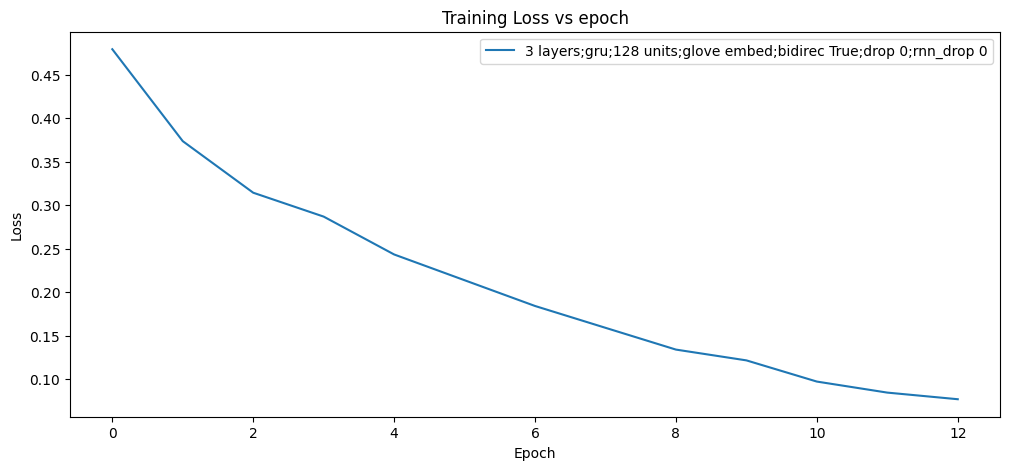

In [ ]:
embedding_layer_type = 'glove'
bidirectional = True
rnn_drop_rate = 0
drop_rate = 0

num_param, val_loss, val_acc, train_time, infer_time = train_model(
    x_train,
    y_train,
    x_val,
    y_val,
    rnn_type=best_rnn_type,
    num_rnn_layers=best_num_rnn_layer,
    rnn_layer_unit=best_rnn_layer_unit,
    embedding_layer_type=embedding_layer_type,
    bidirectional=bidirectional,
    rnn_drop_rate=rnn_drop_rate,
    drop_rate=drop_rate
)

print(f"{best_num_rnn_layer} layers;{best_rnn_type};{best_rnn_layer_unit} units;{embedding_layer_type} embed;bidirec {bidirectional};drop {drop_rate};rnn_drop {rnn_drop_rate} => {num_param} Params;val_loss={val_loss};val_acc={round(val_acc,2)};train_time={round(train_time,2)}s;infer_time={round(infer_time,2)}s")

result_df.loc[len(result_df.index)] = [
    best_rnn_type,
    best_num_rnn_layer,
    best_rnn_layer_unit,
    embedding_layer_type,
    bidirectional,
    rnn_drop_rate,
    drop_rate,
    num_param,
    val_loss,
    val_acc,
    train_time,
    infer_time
]

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title(f'Training Loss vs epoch')
plt.show()


In [ ]:
result_df


,RNN Type,RNN Layer,RNN Size,Embedding Layer,Bidirectional,RNN Dropout Rate,Dropout Rate,Num Params,Val Loss,Val Accuracy,Train Time (s),Infer Time (s)
0,lstm,1,64,glove,False,0,0,48942,0.569545,0.7310,240.921910,0.466113
1,gru,1,64,glove,False,0,0,38574,0.283425,0.8775,185.895412,0.512385
2,gru,1,32,glove,False,0,0,16366,0.314899,0.8640,189.243573,0.374345
3,gru,1,128,glove,False,0,0,101422,0.292553,0.8850,225.282186,0.609460
4,gru,2,128,glove,False,0,0,200494,0.310638,0.8550,472.700390,1.343001
5,gru,3,128,glove,False,0,0,299566,0.274084,0.8930,740.848774,1.574941
6,gru,4,128,glove,False,0,0,398638,0.296770,0.8835,777.693047,1.979421
7,gru,3,128,glove,True,0,0,795438,0.299175,0.8830,694.564792,2.074273


In [ ]:
best_bidirectional = result_df.sort_values(
    by=['Val Accuracy', 'Val Loss'],
    ascending=[False, True]
)['Bidirectional'].iloc[0]

best_bidirectional


False

## Task 7

For the best model above try Dropout: 0.1, Recurrent Dropout:0.2, and both together.

3 layers;gru;128 units;glove embed;bidirec False;drop 0.1;rnn_drop 0 => 299566 Params;val_loss=0.2802678644657135;val_acc=0.88;train_time=696.63s;infer_time=1.67s
3 layers;gru;128 units;glove embed;bidirec False;drop 0;rnn_drop 0.2 => 299566 Params;val_loss=0.24916750192642212;val_acc=0.89;train_time=757.42s;infer_time=1.52s
3 layers;gru;128 units;glove embed;bidirec False;drop 0.1;rnn_drop 0.2 => 299566 Params;val_loss=0.24427096545696259;val_acc=0.9;train_time=1084.17s;infer_time=1.71s


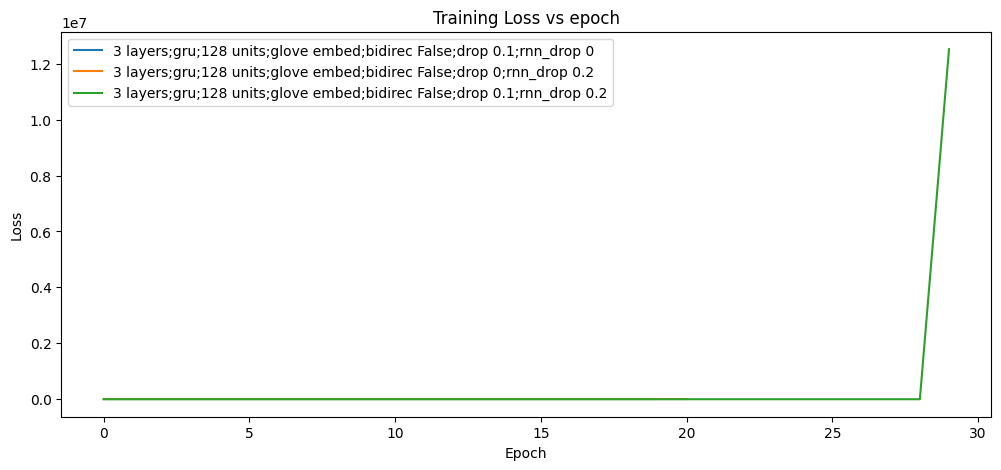

In [ ]:
embedding_layer_type = 'glove'
rnn_drop_rates = [0, 0.2, 0.2]
drop_rates = [0.1, 0, 0.1]

for rnn_drop_rate, drop_rate in zip(rnn_drop_rates, drop_rates):
    num_param, val_loss, val_acc, train_time, infer_time = train_model(
        x_train,
        y_train,
        x_val,
        y_val,
        rnn_type=best_rnn_type,
        num_rnn_layers=best_num_rnn_layer,
        rnn_layer_unit=best_rnn_layer_unit,
        embedding_layer_type=embedding_layer_type,
        bidirectional=best_bidirectional,
        rnn_drop_rate=rnn_drop_rate,
        drop_rate=drop_rate
    )

    print(f"{best_num_rnn_layer} layers;{best_rnn_type};{best_rnn_layer_unit} units;{embedding_layer_type} embed;bidirec {best_bidirectional};drop {drop_rate};rnn_drop {rnn_drop_rate} => {num_param} Params;val_loss={val_loss};val_acc={round(val_acc,2)};train_time={round(train_time,2)}s;infer_time={round(infer_time,2)}s")

    result_df.loc[len(result_df.index)] = [
        best_rnn_type,
        best_num_rnn_layer,
        best_rnn_layer_unit,
        embedding_layer_type,
        best_bidirectional,
        rnn_drop_rate,
        drop_rate,
        num_param,
        val_loss,
        val_acc,
        train_time,
        infer_time
    ]

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title(f'Training Loss vs epoch')
plt.show()


In [ ]:
result_df


,RNN Type,RNN Layer,RNN Size,Embedding Layer,Bidirectional,RNN Dropout Rate,Dropout Rate,Num Params,Val Loss,Val Accuracy,Train Time (s),Infer Time (s)
0,lstm,1,64,glove,False,0.0,0.0,48942,0.569545,0.7310,240.921910,0.466113
1,gru,1,64,glove,False,0.0,0.0,38574,0.283425,0.8775,185.895412,0.512385
2,gru,1,32,glove,False,0.0,0.0,16366,0.314899,0.8640,189.243573,0.374345
3,gru,1,128,glove,False,0.0,0.0,101422,0.292553,0.8850,225.282186,0.609460
4,gru,2,128,glove,False,0.0,0.0,200494,0.310638,0.8550,472.700390,1.343001
5,gru,3,128,glove,False,0.0,0.0,299566,0.274084,0.8930,740.848774,1.574941
6,gru,4,128,glove,False,0.0,0.0,398638,0.296770,0.8835,777.693047,1.979421
7,gru,3,128,glove,True,0.0,0.0,795438,0.299175,0.8830,694.564792,2.074273
8,gru,3,128,glove,False,0.0,0.1,299566,0.280268,0.8845,696.628811,1.670645
9,gru,3,128,glove,False,0.2,0.0,299566,0.249168,0.8925,757.417940,1.516263


In [ ]:
best_rnn_drop_rate = result_df.sort_values(
    by=['Val Accuracy', 'Val Loss'],
    ascending=[False, True]
)['RNN Dropout Rate'].iloc[0]

best_rnn_drop_rate


0.2

In [ ]:
best_drop_rate = result_df.sort_values(
    by=['Val Accuracy', 'Val Loss'],
    ascending=[False, True]
)['Dropout Rate'].iloc[0]

best_drop_rate


0.1

## Task 8/9

For the best model above consider training a self trainable embedding layer, and one hot encoding layer. Discuss the major differences in performance.

3 layers;gru;128 units;trainable_embedding embed;bidirec False;drop 0.1;rnn_drop 0.2 => 3150566 Params;val_loss=0.2810792624950409;val_acc=0.89;train_time=708.96s;infer_time=1.58s


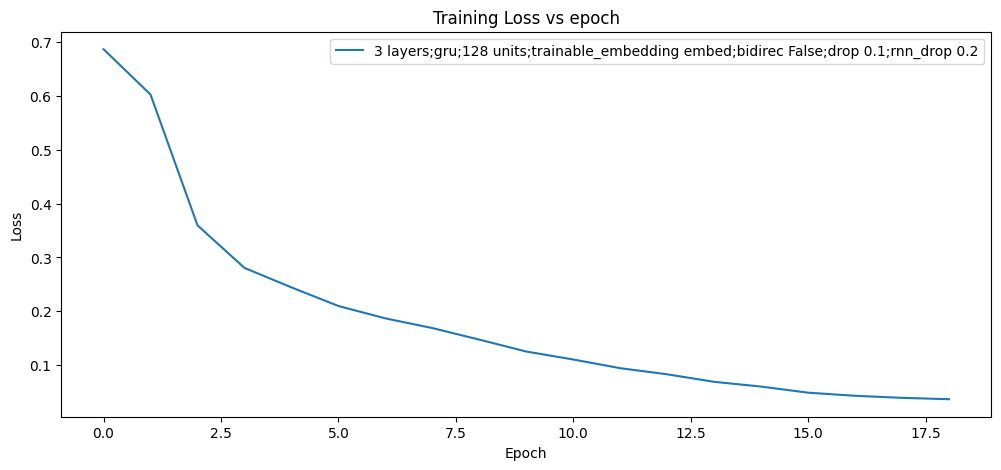

In [ ]:
# one_hot skipped because of RAM limitation
# unable to create 40k x 40k matrix
embedding_layer_types = ['trainable_embedding']

for embedding_layer_type in embedding_layer_types:
    num_param, val_loss, val_acc, train_time, infer_time = train_model(
        x_train,
        y_train,
        x_val,
        y_val,
        rnn_type=best_rnn_type,
        num_rnn_layers=best_num_rnn_layer,
        rnn_layer_unit=best_rnn_layer_unit,
        embedding_layer_type=embedding_layer_type,
        bidirectional=best_bidirectional,
        rnn_drop_rate=best_rnn_drop_rate,
        drop_rate=best_drop_rate
    )

    print(f"{best_num_rnn_layer} layers;{best_rnn_type};{best_rnn_layer_unit} units;{embedding_layer_type} embed;bidirec {best_bidirectional};drop {best_drop_rate};rnn_drop {best_rnn_drop_rate} => {num_param} Params;val_loss={val_loss};val_acc={round(val_acc,2)};train_time={round(train_time,2)}s;infer_time={round(infer_time,2)}s")

    result_df.loc[len(result_df.index)] = [
        best_rnn_type,
        best_num_rnn_layer,
        best_rnn_layer_unit,
        embedding_layer_type,
        best_bidirectional,
        best_rnn_drop_rate,
        best_drop_rate,
        num_param,
        val_loss,
        val_acc,
        train_time,
        infer_time
    ]

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title(f'Training Loss vs epoch')
plt.show()


In [ ]:
result_df


,RNN Type,RNN Layer,RNN Size,Embedding Layer,Bidirectional,RNN Dropout Rate,Dropout Rate,Num Params,Val Loss,Val Accuracy,Train Time (s),Infer Time (s)
0,lstm,1,64,glove,False,0.0,0.0,48942,0.569545,0.7310,240.921910,0.466113
1,gru,1,64,glove,False,0.0,0.0,38574,0.283425,0.8775,185.895412,0.512385
2,gru,1,32,glove,False,0.0,0.0,16366,0.314899,0.8640,189.243573,0.374345
3,gru,1,128,glove,False,0.0,0.0,101422,0.292553,0.8850,225.282186,0.609460
4,gru,2,128,glove,False,0.0,0.0,200494,0.310638,0.8550,472.700390,1.343001
5,gru,3,128,glove,False,0.0,0.0,299566,0.274084,0.8930,740.848774,1.574941
6,gru,4,128,glove,False,0.0,0.0,398638,0.296770,0.8835,777.693047,1.979421
7,gru,3,128,glove,True,0.0,0.0,795438,0.299175,0.8830,694.564792,2.074273
8,gru,3,128,glove,False,0.0,0.1,299566,0.280268,0.8845,696.628811,1.670645
9,gru,3,128,glove,False,0.2,0.0,299566,0.249168,0.8925,757.417940,1.516263


In [ ]:
best_embedding_layer_type = result_df.sort_values(
    by=['Val Accuracy', 'Val Loss'],
    ascending=[False, True]
)['Embedding Layer'].iloc[0]

best_embedding_layer_type


'glove'

## Task 10

Compare the number of parameters, training and inference computation time, Training Loss graph, accuracy.


In [ ]:
result_df


,RNN Type,RNN Layer,RNN Size,Embedding Layer,Bidirectional,RNN Dropout Rate,Dropout Rate,Num Params,Val Loss,Val Accuracy,Train Time (s),Infer Time (s)
0,lstm,1,64,glove,False,0.0,0.0,48942,0.569545,0.7310,240.921910,0.466113
1,gru,1,64,glove,False,0.0,0.0,38574,0.283425,0.8775,185.895412,0.512385
2,gru,1,32,glove,False,0.0,0.0,16366,0.314899,0.8640,189.243573,0.374345
3,gru,1,128,glove,False,0.0,0.0,101422,0.292553,0.8850,225.282186,0.609460
4,gru,2,128,glove,False,0.0,0.0,200494,0.310638,0.8550,472.700390,1.343001
5,gru,3,128,glove,False,0.0,0.0,299566,0.274084,0.8930,740.848774,1.574941
6,gru,4,128,glove,False,0.0,0.0,398638,0.296770,0.8835,777.693047,1.979421
7,gru,3,128,glove,True,0.0,0.0,795438,0.299175,0.8830,694.564792,2.074273
8,gru,3,128,glove,False,0.0,0.1,299566,0.280268,0.8845,696.628811,1.670645
9,gru,3,128,glove,False,0.2,0.0,299566,0.249168,0.8925,757.417940,1.516263


## Task 11

Write a review of your own and test your model. Save the model
checkpoint for later use. [Note: To verify the best model is saved, re-run
the notebook and only perform testing]

In [ ]:
print(f"best_rnn_type = {best_rnn_type}")
print(f"best_num_rnn_layer = {best_num_rnn_layer}")
print(f"best_rnn_layer_unit = {best_rnn_layer_unit}")
print(f"best_embedding_layer_type = {best_embedding_layer_type}")
print(f"best_bidirectional = {best_bidirectional}")
print(f"best_rnn_drop_rate = {best_rnn_drop_rate}")
print(f"best_drop_rate = {best_drop_rate}")

best_rnn_type = gru
best_num_rnn_layer = 3
best_rnn_layer_unit = 128
best_embedding_layer_type = glove
best_bidirectional = False
best_rnn_drop_rate = 0.2
best_drop_rate = 0.1


In [ ]:
model = train_model(
        x_train,
        y_train,
        x_val,
        y_val,
        rnn_type=best_rnn_type,
        num_rnn_layers=best_num_rnn_layer,
        rnn_layer_unit=best_rnn_layer_unit,
        embedding_layer_type=best_embedding_layer_type,
        bidirectional=best_bidirectional,
        rnn_drop_rate=best_rnn_drop_rate,
        drop_rate=best_drop_rate,
        give_model=True
    )

In [ ]:
val_loss, val_acc = model.evaluate(x_test, y_test)

print(f"val_loss = {val_loss}")
print(f"val_acc  = {val_acc }")

63/63 [==============================] - 2s 27ms/step - loss: 0.2473 - accuracy: 0.9000
val_loss = 0.24732160568237305
val_acc  = 0.8999999761581421


In [ ]:
model.save('best_model')

INFO:tensorflow:Assets written to: best_model/assets


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('best_model')
val_loss, val_acc = model.evaluate(x_test, y_test)

print(f"val_loss = {val_loss}")
print(f"val_acc  = {val_acc }")

63/63 [==============================] - 2s 34ms/step - loss: 0.2473 - accuracy: 0.9000
val_loss = 0.24732160568237305
val_acc  = 0.8999999761581421


## Task 12

For the best model try the Hindi movie review dataset https://www.kaggle.com/disisbig/hindi-movie-reviews-dataset (use self trainable embedding layer or any other Hindi Word2Vec representation).

In [ ]:
HINDI_REVIEW_TRAIN_PATH = "./../ML_DRIVE/Assign_7/Hindi Movie/train.csv"
HINDI_REVIEW_VAL_PATH = "./../ML_DRIVE/Assign_7/Hindi Movie/valid.csv"

In [ ]:
import pandas as pd

hindi_train_df = pd.read_csv(HINDI_REVIEW_TRAIN_PATH)
hindi_val_df = pd.read_csv(HINDI_REVIEW_VAL_PATH)

hindi_train_df

,text,experience
0,चंद्रमोहन शर्मा को-प्रड्यूसर और लीड ऐक्टर अक्ष...,2
1,अगर आप इस फिल्म को देखने जा रहे हैं तो सबसे पह...,0
2,बॉलीवुड वाले चोरी-छिपे हॉलीवुड फिल्मों से कहान...,2
3,"बैनर :\nसंजय दत्त प्रोडक्शन्स प्रा.लि., रुपाली...",0
4,1959 में घटित चर्चित नानावटी कांड में एक क्राइ...,1
...,...,...
713,31 अक्टूबर 1984 को काला दिवस कहा जाता है। इस द...,1
714,\n\nगुंडे को देख सत्तर और अस्सी के दशक का सिने...,1
715,Chandermohan.sharma@timesgroup.com ग्लैमर इंडस...,2
716,"निर्माता :\nसुनीता गोवारीकर, अजय बिजली, संजीव ...",2


In [ ]:
hindi_train_df['experience'] = np.where(
    hindi_train_df['experience'] >= 1, 1, 0
)

hindi_val_df['experience'] = np.where(
    hindi_val_df['experience'] >= 1, 1, 0
)

In [ ]:
from tensorflow.keras.layers import TextVectorization

vectorizer = TextVectorization(output_sequence_length=100)
vectorizer.adapt(hindi_train_df['text'].to_list())
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'के', 'है।', 'में']

In [ ]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))
num_tokens = len(voc) + 2  # +2 for "empty" and "unknown"
embedding_dim = 100  # cause using glove 100 model

In [ ]:
hindi_x_train =  vectorizer(
    np.array(
        [[s] for s in hindi_train_df['text'].tolist()]
    )
).numpy()

hindi_x_val =  vectorizer(
    np.array(
        [[s] for s in hindi_val_df['text'].tolist()]
    )
).numpy()

In [ ]:
from tensorflow.keras.utils import to_categorical

hindi_y_train = to_categorical(hindi_train_df['experience'].tolist())
hindi_y_val = to_categorical(hindi_val_df['experience'].tolist())

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input

hindi_model = Sequential()
hindi_model.add(Input(shape=(None, ), dtype="int64"))
hindi_model.add(Embedding(num_tokens, embedding_dim))

for layer in model.layers[1:]:
    hindi_model.add(layer)
    hindi_model.layers[-1].trainable = False

hindi_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         2281600   
                                                                 
 dropout_12 (Dropout)        (None, None, 100)         0         
                                                                 
 gru_27 (GRU)                (None, None, 128)         88320     
                                                                 
 dropout_13 (Dropout)        (None, None, 128)         0         
                                                                 
 gru_28 (GRU)                (None, None, 128)         99072     
                                                                 
 dropout_14 (Dropout)        (None, None, 128)         0         
                                                                 
 gru_29 (GRU)                (None, 128)              

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    loss="categorical_crossentropy", metrics=["accuracy"]
)

callback = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
]

history = model.fit(
    hindi_x_train,
    hindi_y_train,
    epochs=100,
    validation_data=(hindi_x_val, hindi_y_val),
    callbacks=callback,
    verbose=2
)


Epoch 1/100
23/23 - 6s - loss: 0.9936 - accuracy: 0.5056 - val_loss: 0.2473 - val_accuracy: 0.9000 - 6s/epoch - 243ms/step
Epoch 2/100
23/23 - 3s - loss: 0.9819 - accuracy: 0.5223 - val_loss: 0.2473 - val_accuracy: 0.9000 - 3s/epoch - 142ms/step
Epoch 3/100
23/23 - 3s - loss: 0.9803 - accuracy: 0.5028 - val_loss: 0.2473 - val_accuracy: 0.9000 - 3s/epoch - 141ms/step
Epoch 4/100
23/23 - 3s - loss: 0.9939 - accuracy: 0.5265 - val_loss: 0.2473 - val_accuracy: 0.9000 - 3s/epoch - 141ms/step
Epoch 5/100
23/23 - 4s - loss: 1.0033 - accuracy: 0.5125 - val_loss: 0.2473 - val_accuracy: 0.9000 - 4s/epoch - 154ms/step
Epoch 6/100
23/23 - 4s - loss: 0.9552 - accuracy: 0.5320 - val_loss: 0.2473 - val_accuracy: 0.9000 - 4s/epoch - 171ms/step
Epoch 7/100
23/23 - 4s - loss: 0.9923 - accuracy: 0.5237 - val_loss: 0.2473 - val_accuracy: 0.9000 - 4s/epoch - 154ms/step
Epoch 8/100
23/23 - 4s - loss: 0.9578 - accuracy: 0.5362 - val_loss: 0.2473 - val_accuracy: 0.9000 - 4s/epoch - 161ms/step
Epoch 9/100
23/2

## Task 13

Discuss the time required and other practical challenges in training with the whole Amazon review dataset.

1. My Whole 16 GB RAM was near occupied with only 12000 observations, actual dataset have 568454 rows, hence we need abysmal amount of RAM to store its embedding (unique_words * 100) (100 cause of glove 100)

2. This notebook takes like 2 hours to fully run with only 12000 observations, actual dataset have 568454 rows, hence we need abysmal Training Time also

3. Model parameters did not allows GPU acceleration to work